In [ ]:
# set visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [1]:
# set the cwd to the root of the repo

import os
# change dir to root of repo
os.chdir('..')

import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.models.reni_neus import RENINeuSModel, RENINeuSModelConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.fields.reni_field import get_directions
from nerfstudio.fields.reni_field import RENIField, get_directions, get_sineweight
from nerfstudio.cameras.rays import RayBundle

def make_ray_bundle_copy(ray_bundle):
    new_ray_bundle = RayBundle(
      origins=ray_bundle.origins.detach().clone(),
      directions=ray_bundle.directions.detach().clone(),
      pixel_area=ray_bundle.pixel_area.detach().clone(),
      directions_norm=ray_bundle.directions_norm.detach().clone(),
      camera_indices=ray_bundle.camera_indices.detach().clone(),
      nears=ray_bundle.nears.detach().clone() if ray_bundle.nears is not None else None,
      fars=ray_bundle.fars.detach().clone() if ray_bundle.fars is not None else None,
    )
    return new_ray_bundle

def make_batch_clone(batch):
    new_batch = {}
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            new_batch[key] = value.detach().clone()
        else:
            new_batch[key] = value
    return new_batch       

def sRGB(imgs):
    # if shape is not B, C, H, W, then add batch dimension
    if len(imgs.shape) == 3:
        imgs = imgs.unsqueeze(0)
    q = torch.quantile(torch.quantile(torch.quantile(imgs, 0.98, dim=(1)), 0.98, dim=(1)), 0.98, dim=(1))
    imgs = imgs / q.unsqueeze(1).unsqueeze(2).unsqueeze(3)
    imgs = torch.clamp(imgs, 0.0, 1.0)
    imgs = torch.where(
        imgs <= 0.0031308,
        12.92 * imgs,
        1.055 * torch.pow(torch.abs(imgs), 1 / 2.4) - 0.055,
    )
    return imgs

def rotation_matrix(axis, angle):
    """
    Return 3D rotation matrix for rotating around the given axis by the given angle.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

ckpt_path = 'outputs/data-NeRF-OSR-Data/RENI-NeuS/latest_with_rot_and_clip_illumination/'
step = 80000

ckpt = torch.load(ckpt_path + '/sdfstudio_models' + f'/step-{step:09d}.ckpt', map_location=device)
model_dict = {}
for key in ckpt['pipeline'].keys():
    if key.startswith('_model.'):
        model_dict[key[7:]] = ckpt['pipeline'][key]

# load yaml checkpoint config
config_path = Path(ckpt_path) / 'config.yml'
config = yaml.load(config_path.open(), Loader=yaml.Loader)

pipeline_config = config.pipeline
pipeline_config.datamanager.dataparser.scene = 'lk2'
pipeline_config.datamanager.dataparser.use_session_data = False

# if illumination_sampler_random_rotation not in pipeline.config.model add it and set to false
try:
    pipeline_config.model.illumination_sampler_random_rotation
except AttributeError:
    pipeline_config.model.illumination_sampler_random_rotation = True
try:
    pipeline_config.model.illumination_sample_remove_lower_hemisphere
except AttributeError:
    pipeline_config.model.illumination_sample_remove_lower_hemisphere = True

datamanager: VanillaDataManager = pipeline_config.datamanager.setup(
    device=device, test_mode=test_mode, world_size=world_size, local_rank=local_rank, 
)
datamanager.to(device)
# includes num_eval_data as needed for reni latent code fitting.
model = pipeline_config.model.setup(
    scene_box=datamanager.train_dataset.scene_box,
    num_train_data=len(datamanager.train_dataset),
    num_eval_data=len(datamanager.eval_dataset),
    metadata=datamanager.train_dataset.metadata,
    world_size=world_size,
    local_rank=local_rank,
    eval_latent_optimisation_source=pipeline_config.eval_latent_optimisation_source,
)
model.to(device)

model.load_state_dict(model_dict)
model.eval()

image_idx_original, camera_ray_bundle_original, batch_original = datamanager.next_eval_image(1)

True # printing to hide long cell output

Loading data batch ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

True

mlp($\hat{x}, d$) where $x = \hat{x}r$

$||x|| = ||d|| = 1$

Losses:

1. DDF->SDF Level Set 
2. Ray Hit Probability Supervision -> SDF Accumulation 
3. SDF Expected Termination Supervisioni -> SDF Accumulation
4. Multiview consitancy -> other point on sphere $x_{2}$ looking at same point must have $f_{\text{DDF}} <= 


Now we need to generate a lot of random positions on a unit sphere and directions but directions need to be only in the hemisphere of the inward facing normal from the point on the sphere.

In [3]:
import torch
import plotly.graph_objects as go
import numpy as np

def random_points_on_unit_sphere(num_points, cartesian=False):
    theta = 2 * torch.pi * torch.rand(num_points)
    phi = torch.acos(2 * torch.rand(num_points) - 1)
    if cartesian:
        return torch.stack(sph2cart(theta, phi), dim=1)
    return torch.stack([theta, phi], dim=1)

def random_inward_facing_directions(num_directions, normals):
    # num_directions = scalar
    # normals = (N, 3)
    # returns (N, num_directions, 3)

    # For each normal get a random set of directions
    directions = random_points_on_unit_sphere(num_directions * normals.shape[0], cartesian=True)
    directions = directions.reshape(normals.shape[0], num_directions, 3)

    # remove any directions that are not in the hemisphere of the associated normal
    dot_products = torch.sum(normals.unsqueeze(1) * directions, dim=2)
    mask = dot_products < 0

    # negate the directions that are not in the hemisphere
    directions[mask] = -directions[mask]

    return directions    

def sph2cart(theta, phi):
    x = torch.sin(phi) * torch.cos(theta)
    y = torch.sin(phi) * torch.sin(theta)
    z = torch.cos(phi)
    return x, y, z

def cart2sph(x, y, z):
    r = torch.sqrt(x**2 + y**2 + z**2)
    theta = torch.atan2(y, x)
    phi = torch.acos(z / r)
    return theta, phi


from torch.utils.data import Dataset

class DDFSDFDataset(Dataset):
    def __init__(self, num_directions, ddf_sphere_radius, sdf_function, device):
        self.sdf_function = sdf_function
        self.ddf_sphere_radius = ddf_sphere_radius
        self.num_directions = num_directions
        self.device = device
        # generate a H and W from number of directions
        self.H = int(np.sqrt(self.num_directions))
        self.W = int(np.sqrt(self.num_directions))

        origins = torch.zeros(self.H, self.W, 1, 3, device=device)
        directions = torch.ones(self.H, self.W, 1, 3, device=device)
        pixel_area = torch.ones(self.H, self.W, 1, 1, device=device)
        directions_norm = torch.ones(self.H, self.W, 1, 1, device=device)
        # camera indices should be int64
        camera_indices = torch.zeros(self.H, self.W, 1, 1, device=device, dtype=torch.int64)
        nears = torch.ones(self.H, self.W, 1, 1, device=device) * sdf_function.scene_box.near
        fars = torch.ones(self.H, self.W, 1, 1, device=device) * sdf_function.scene_box.far

        self.ray_bundle = RayBundle(
                              origins=origins,
                              directions=directions,
                              pixel_area=pixel_area,
                              directions_norm=directions_norm,
                              camera_indices=camera_indices,
                              nears=nears,
                              fars=fars
                          )

    def __len__(self):
        return self.num_positions
        

    def _generate_sample(self):
        positions = random_points_on_unit_sphere(1, cartesian=True) # (1, 3)
        directions = random_inward_facing_directions(self.num_directions, normals=-positions) # (1, num_directions, 3)
        
        # scale positions from unit sphere to ddf_sphere_radius
        positions = positions * self.ddf_sphere_radius
        
        pos_ray = positions.unsqueeze(1).unsqueeze(1).expand(self.H, self.W, 1, -1).to(self.device)
        dir_ray = directions.reshape(self.H, self.W, 3).unsqueeze(2).to(self.device)

        self.ray_bundle.origins = pos_ray
        self.ray_bundle.directions = dir_ray
        field_outputs = self.sdf_function.get_outputs_for_camera_ray_bundle(self.ray_bundle)
        accumultation = field_outputs["accumulation"].reshape(-1, 1).squeeze()
        termination_dist = field_outputs["depth"].reshape(-1, 1)

        directions = directions.squeeze(0)
        positions = positions.repeat(directions.shape[0], 1)

        return positions, directions, accumultation, termination_dist
        
    def __getitem__(self, idx):
        return self._generate_sample()


Generating output for camera... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━  97% 0:00:01

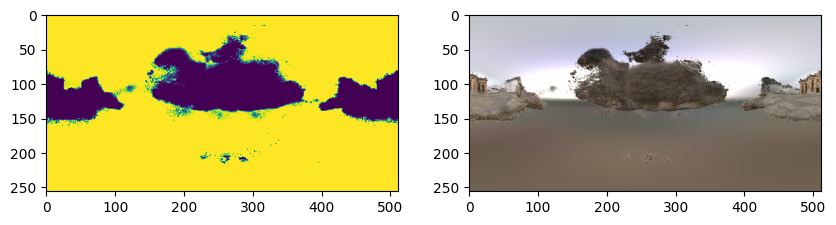

In [16]:
# camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
# batch = make_batch_clone(batch_original)

W = 512
H = W // 2

directions = get_directions(W).squeeze(0).reshape(H, W, 3).unsqueeze(2).to(device) # [H, W, 1, 3]
# swap Y and Z axes and invert X axis
directions = torch.stack([directions[..., 0] * -1, directions[..., 2], directions[..., 1]], dim=-1)

# select only H, W worth of each element of the camera ray bundle
camera_ray_bundle = camera_ray_bundle[:H, :W]
camera_ray_bundle.directions = directions # [H, W, 1, 3]

origins = random_points_on_unit_sphere(1, cartesian=True) # [1, 3]
origins = origins.unsqueeze(0).unsqueeze(0).repeat(H, W, 1, 1).to(device) # [H, W, 1, 3]

camera_ray_bundle.origins = origins

camera_ray_bundle.directions_norm = torch.ones_like(camera_ray_bundle.directions_norm).to(device)

# set all pixel areas to 1
camera_ray_bundle.pixel_area = torch.ones_like(camera_ray_bundle.pixel_area).to(device) * 0.01

# set all nears to 0.05
camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near
# set all fars to 100
camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far

model.config.eval_num_rays_per_chunk = 2048

outputs = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle, show_progress=True)

accumulation = outputs['accumulation'].cpu().detach().numpy()
visibiltiy = 1.0 - accumulation
rgb = outputs['rgb'].cpu().detach().numpy()

# plot both in the same figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(visibiltiy)
ax[1].imshow(rgb)

In [7]:
num_positions = 2
num_directions = 15
positions = random_points_on_unit_sphere(num_positions, cartesian=True)
normals = -positions
directions = random_inward_facing_directions(num_directions, normals)

# plot position as point and normal as line with arrow head using plotly
fig = go.Figure()

# Add position points
fig.add_trace(go.Scatter3d(x=positions[:, 0], y=positions[:, 1], z=positions[:, 2], mode='markers'))

# Add normal vector lines
for position, normal in zip(positions, normals):
    fig.add_trace(go.Scatter3d(x=[position[0], normal[0]+position[0]], y=[position[1], normal[1]+position[1]], z=[position[2], normal[2]+position[2]], mode='lines', line=dict(width=15)))


for i, position in enumerate(positions):
    for j, direction in enumerate(directions[i]):
        # Add direction vector lines
        fig.add_trace(go.Scatter3d(x=[position[0], direction[0]+position[0]], y=[position[1], direction[1]+position[1]], z=[position[2], direction[2]+position[2]], mode='lines', line=dict(width=5)))

# set square and all axes equal
fig.update_layout(
    scene=dict(
        aspectmode='cube',
        xaxis=dict(range=[-2, 2], autorange=False, zeroline=False),
        yaxis=dict(range=[-2, 2], autorange=False, zeroline=False),
        zaxis=dict(range=[-2, 2], autorange=False, zeroline=False),
    )
)

fig.show()

In [8]:
# Setup DDF Field
from nerfstudio.field_components.encodings import SHEncoding
import tinycudann as tcnn

def get_normalized_tensor(t):
    """SH encoding must be in the range [0, 1]

    Args:
        t: batch of vectors
    """
    return (t + 1.0) / 2.0

position_encoding = SHEncoding(4)
direction_encoding = SHEncoding(4)

hidden_dim_ddf = 128
num_layers_ddf = 4
output_dim_ddf = 2 # Scalar distance and probability of termination

ddf = tcnn.Network(
    n_input_dims=6
    + position_encoding.get_out_dim()
    + direction_encoding.get_out_dim(),
    n_output_dims=output_dim_ddf,
    network_config={
        "otype": "FullyFusedMLP",
        "activation": "ReLU",
        "output_activation": "None",
        "n_neurons": hidden_dim_ddf,
        "n_hidden_layers": num_layers_ddf - 1,
    },
)

ddf.to(device)

Network(n_input_dims=38, n_output_dims=2, seed=1337, dtype=torch.float16, hyperparams={'encoding': {'offset': 0.0, 'otype': 'Identity', 'scale': 1.0}, 'network': {'activation': 'ReLU', 'n_hidden_layers': 3, 'n_neurons': 128, 'otype': 'FullyFusedMLP', 'output_activation': 'None'}, 'otype': 'NetworkWithInputEncoding'})

In [11]:
import wandb

# Initialize a new W&B run
wandb.init(project="ddf")

# setup optimizer and training loop
optim = torch.optim.Adam(ddf.parameters(), lr=1e-4)
sdf_loss = torch.nn.MSELoss()
hit_probability_loss = torch.nn.BCEWithLogitsLoss()
expected_termination_loss = torch.nn.MSELoss()

dataset = DDFSDFDataset(100, 1.0, model, device)

for i in range(5000):
    positions, directions, accumultation, termination_dist = dataset[0]
    positions = positions.to(device)
    directions = directions.to(device)
    accumultation = accumultation.to(device)
    termination_dist = termination_dist.to(device)

    encoded_positions = position_encoding(get_normalized_tensor(positions))
    encoded_directions = direction_encoding(get_normalized_tensor(directions))

    model_input = torch.cat([positions, directions, encoded_positions, encoded_directions], dim=-1)
    
    output = ddf(model_input).type(torch.float32)
    expected_termination_dist = torch.relu(output[..., 0])
    probability_of_hit = torch.sigmoid(output[..., 1])

    # get sdf at expected termination distance
    sdf_at_termination = model.field.get_sdf_at_pos(positions + directions * expected_termination_dist.unsqueeze(-1))
    
    l1 = 1.0 * sdf_loss(sdf_at_termination, torch.zeros_like(sdf_at_termination))
    l2 = 1.0 * hit_probability_loss(probability_of_hit, accumultation)
    l3 = 3.0 * expected_termination_loss(expected_termination_dist, termination_dist)

    loss = l1 + l2 + l3
    
    optim.zero_grad()
    loss.backward()
    optim.step()

    # Log losses to W&B
    wandb.log({"sdf_loss": l1.item(), "hit_loss": l2.item(), "term_loss": l3.item(), "total_loss": loss.item()})

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: uoy-jadgardner. Use `wandb login --relogin` to force relogin


/home/user/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning:

Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



hit_loss,▅▇▅▇▆▇▆▃▇▅▅▄▆▆▅█▄▆▆▅▄▅▄▃▇▅▄▁▅▆▅▂▇▅▆▇▆▇▆▆
sdf_loss,▃▇▅▅▂▇▅▁▆▅▃▁▅▅▅▅▁▅▅▂▂▂▂▁▇▄▅▂▅▅▄▁▄▆▆▆▁█▅▅
term_loss,▅▄▄▄▄▃▅▂▂▆▅▂▄▄█▅▃▆▄▄▄▃▇▂▃▃▆▁▅▂▄▁▄▅▂▃█▂▄▄
total_loss,▅▅▅▅▅▅▆▂▄▆▅▃▅▅█▆▃▆▅▄▄▄▇▂▄▄▆▁▆▃▅▁▅▆▃▄█▄▅▅
hit_loss,0.65804
sdf_loss,0.10465
term_loss,0.40325
total_loss,1.16594


Generating output for camera... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━  97% 0:00:01

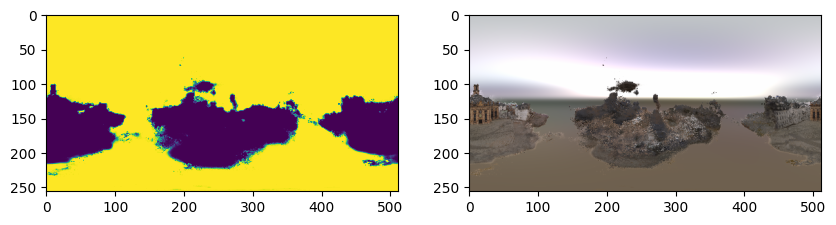

In [31]:
camera_ray_bundle.camera_indices.dtype

torch.int64